# Two classes image classification using Xception-convolutional-neural network

This tutorial aims to demonstrate how to classify two classes of images, i.e., komodo and trilobite. It is tested on AWS using instance ml.c5.2xlarge (trained on CPU). Both classes have 2964 images in total and use computational time less than three hours on Sagemaker, which cost around $2. Note that this work based JupyterLab with compiling on Python 3 kernel.

# Data hierarchy

Input images require to have a data structure as indicate bleow
- dataset<br>
    |----- class_1<br>
    &emsp;      -- name1.jpg<br>
    &emsp;      -- name2.jpg<br>
    &emsp;      .<br>
    &emsp;      .<br>
    &emsp;      .<br>
    |----- class_2<br>
    &emsp;     -- name1.jpg<br>
    &emsp;     -- name2.jpg<br>
    &emsp;     .<br>
    &emsp;     .<br>
    &emsp;     .<br>

# Check tensorflow and numpy version

In [ ]:
!pip install tf-nightly # fix problem image_dataset_from_directory

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.version.VERSION)
print(np.__version__)

# Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download data from S3 (URLs) for training, validating, and testing

In [2]:
dir_data = 'dataset'
class_1 = 'komodoes'
class_2 = 'trilobites'

### Loading data from S3 bucket (training data)

In [3]:
!curl -O https://project-2-ic.s3-us-west-2.amazonaws.com/dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  404M  100  404M    0     0  2707k      0  0:02:33  0:02:33 --:--:-- 2472k
unzip:  cannot find or open dir_data, dir_data.zip or dir_data.ZIP.


### Uncompressing file

In [5]:
import zipfile

with zipfile.ZipFile(dir_data + '.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Load testing images 

Only two images: one is komodo and another is trilobite. 

In [4]:
!curl -O https://project-2-ic.s3-us-west-2.amazonaws.com/test_images.zip
!unzip -q test_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1107k  100 1107k    0     0   503k      0  0:00:02  0:00:02 --:--:--  503k


# Feature engineering, cleaning data

Execute this cell in case there are unreadble image files

In [6]:
# import os

# num_skipped = 0
# for folder_name in (class_1, class_2):
#     folder_path = os.path.join(dir_data, folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

Deleted 0 images


# Split data for testing and validating

In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2964 files belonging to 2 classes.
Using 2372 files for training.
Found 2964 files belonging to 2 classes.
Using 592 files for validation.


# Visualize first 10 sample images

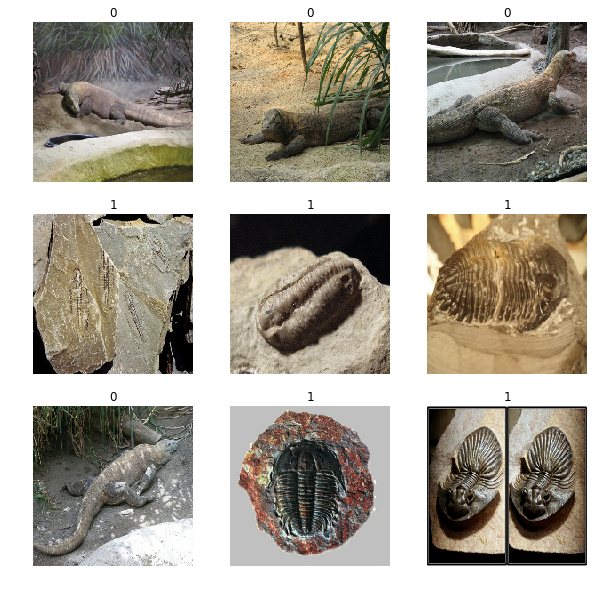

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data augmentation

To avoid overfitting, we use an augmentation technique to flip, rotate, crop, normalize, and adjust the images' colors. This technique can help the algorithm of the neural network can learn the same image better.

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Display examples of image augmentations

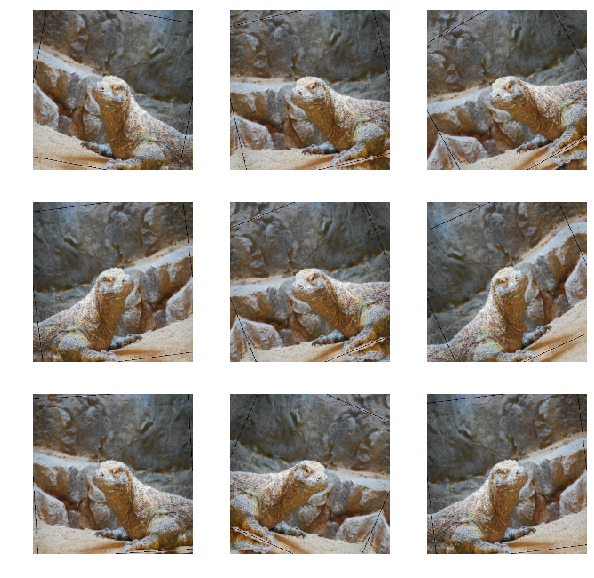

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

### Fetching images as batchs
Buffer size indicates image batches that will use for parallel computation in multiple cores. This technique can reduce computational time. 

In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Xception neural network

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

# Iteration

In [15]:
# epochs = 2 # for quick evaluation
epochs = 50 #  to reach the accuracy 0.97

if not os.path.isdir('save_model'):
    os.mkdir('save_model')

callbacks = [
    keras.callbacks.ModelCheckpoint("./save_model/trained_model_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
75/75 [==============================] - 221s 3s/step - loss: 0.5790 - accuracy: 0.7255 - val_loss: 0.7043 - val_accuracy: 0.4848
Epoch 2/50
75/75 [==============================] - 214s 3s/step - loss: 0.4587 - accuracy: 0.7909 - val_loss: 0.7529 - val_accuracy: 0.4848
Epoch 3/50
75/75 [==============================] - 205s 3s/step - loss: 0.3767 - accuracy: 0.8352 - val_loss: 0.9856 - val_accuracy: 0.4848
Epoch 4/50
75/75 [==============================] - 208s 3s/step - loss: 0.3335 - accuracy: 0.8621 - val_loss: 1.0198 - val_accuracy: 0.4848
Epoch 5/50
75/75 [==============================] - 207s 3s/step - loss: 0.3304 - accuracy: 0.8579 - val_loss: 0.9092 - val_accuracy: 0.4848
Epoch 6/50
75/75 [==============================] - 201s 3s/step - loss: 0.2914 - accuracy: 0.8756 - val_loss: 1.0910 - val_accuracy: 0.4848
Epoch 7/50
75/75 [==============================] - 194s 3s/step - loss: 0.2937 - accuracy: 0.8777 - val_loss: 0.7677 - val_accuracy: 0.5591
Epoch 8/50
75

# Plot training and validation accuracies

We use training and validation accuracies to evaluate how well the algorithm. In several cases, training accuracy reaches 1.0 and yields a poor result. Thus, we need validation accuracy to test the algorithm to avoid overfitting. In our case, the validation accuracy nearly reaches 1.0, but the fluctuation is still. To improve validation accuracy, we might expand the epoch to have a number larger than 50.

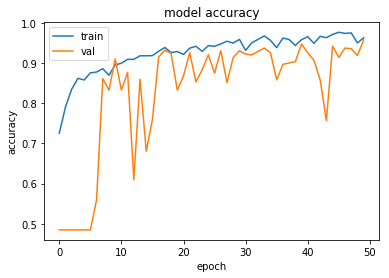

In [16]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot loss and epoch

Similar concept with model accuracy

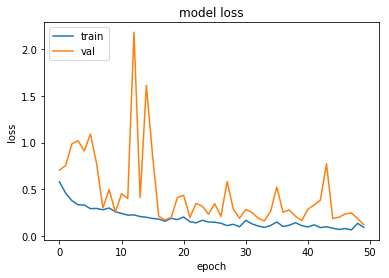

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Display test image

Test image is possible to download from any website and upload to S3.

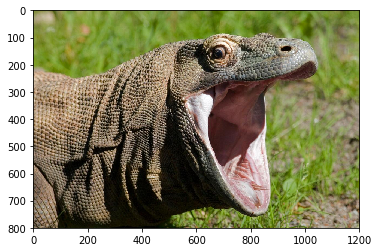

In [18]:
from PIL import Image

test_image = './test_images/komodo.jpg'
image = Image.open(test_image)
plt.imshow(image)
plt.show()

# Convert to human readable percentage

The result is perfect but this image is very similar to the one in training image.

In [19]:
img = keras.preprocessing.image.load_img(test_image, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

print(
    'This image is {} %.2f percent and {} %.2f percent'.format(class_1, class_2)
    % (100 * (1 - score), 100 * score)
)

This image is komodoes 100.00 percent and trilobites 0.00 percent
